# EfficientV2-based Malware Classification with Malimg Dataset

* Prepare by **vomtung@gmail.com**
* Dataset: Malimg - Malware visualization images
* Model: Convolutional Neural Network (CNN)

In [25]:
# Install required packages
%pip install tensorflow keras opencv-python pillow matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


In [27]:
# Load Malimg dataset
print("=== LOADING MALIMG DATASET ===")

dataset_path = 'dataset/malimg/malimg_paper_dataset_imgs'
image_size = (128, 128)  # Increase to 128x128 for EfficientNetV2

# Check if dataset path exists
if not os.path.exists(dataset_path):
    print(f"ERROR: Dataset path '{dataset_path}' does not exist!")
    print(f"Current working directory: {os.getcwd()}")
else:
    print(f"Dataset path found: {dataset_path}")
    print(f"Full path: {os.path.abspath(dataset_path)}")

# Get all malware family folders (these are the labels)
malware_families = []
if os.path.exists(dataset_path):
    all_items = os.listdir(dataset_path)
    print(f"\nAll items in dataset folder: {all_items}")
    
    malware_families = [d for d in all_items 
                       if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')]
    print(f"\nFound {len(malware_families)} malware families:")
    for family in malware_families:
        family_path = os.path.join(dataset_path, family)
        num_files = len([f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))])
        print(f"  - {family}: {num_files} files")

# Load images and labels from each malware family folder
images = []
labels = []

print("\n=== LOADING IMAGES ===")
for family in malware_families:
    family_path = os.path.join(dataset_path, family)
    
    # Get all files in this family folder
    all_files = os.listdir(family_path)
    
    # Filter image files (including .png which is common in Malimg)
    image_files = [f for f in all_files 
                   if os.path.isfile(os.path.join(family_path, f)) and 
                   f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    print(f"\nProcessing '{family}':")
    print(f"  Total files: {len(all_files)}")
    print(f"  Image files: {len(image_files)}")
    
    if len(image_files) > 0:
        print(f"  Sample files: {image_files[:3]}")
    
    loaded_count = 0
    error_count = 0
    
    for img_file in image_files:
        img_path = os.path.join(family_path, img_file)
        try:
            # Read image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                # Resize image to target size
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(family)  # Family name is the label
                loaded_count += 1
            else:
                error_count += 1
                if error_count <= 3:  # Show first 3 errors
                    print(f"  WARNING: cv2.imread returned None for {img_file}")
                
        except Exception as e:
            error_count += 1
            if error_count <= 3:
                print(f"  ERROR loading {img_file}: {e}")
    
    print(f"  Successfully loaded: {loaded_count} images")
    if error_count > 0:
        print(f"  Failed to load: {error_count} images")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"\n=== DATASET SUMMARY ===")
print(f"Total images loaded: {len(images)}")

if len(images) == 0:
    print("ERROR: No images were loaded!")
    print("Please check:")
    print("1. Malware family folders contain image files")
    print("2. Image files have correct extensions (.png, .jpg, etc.)")
    print("3. Image files are not corrupted")
else:
    print(f"Image shape: {images[0].shape}")
    print(f"Number of malware families (classes): {len(np.unique(labels))}")
    
    # Display class distribution
    unique, counts = np.unique(labels, return_counts=True)
    class_distribution = pd.DataFrame({'Malware Family': unique, 'Count': counts})
    class_distribution = class_distribution.sort_values('Count', ascending=False)
    print("\nClass Distribution:")
    print(class_distribution.to_string(index=False))

=== LOADING MALIMG DATASET ===
Dataset path found: dataset/malimg/malimg_paper_dataset_imgs
Full path: e:\master\github\detect-def-attack-lab\dataset\malimg\malimg_paper_dataset_imgs

All items in dataset folder: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'C2LOP.P', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']

Found 25 malware families:
  - Adialer.C: 122 files
  - Agent.FYI: 116 files
  - Allaple.A: 2949 files
  - Allaple.L: 1591 files
  - Alueron.gen!J: 198 files
  - Autorun.K: 106 files
  - C2LOP.gen!g: 200 files
  - C2LOP.P: 146 files
  - Dialplatform.B: 177 files
  - Dontovo.A: 162 files
  - Allaple.A: 2949 files
  - Allaple.L: 1591 files
  - Alueron.gen!J: 198 files
  - Autorun.K: 106 files
  - C2LOP.gen!g: 200 files
  - C2LOP.P: 14

=== VISUALIZING SAMPLE IMAGES ===


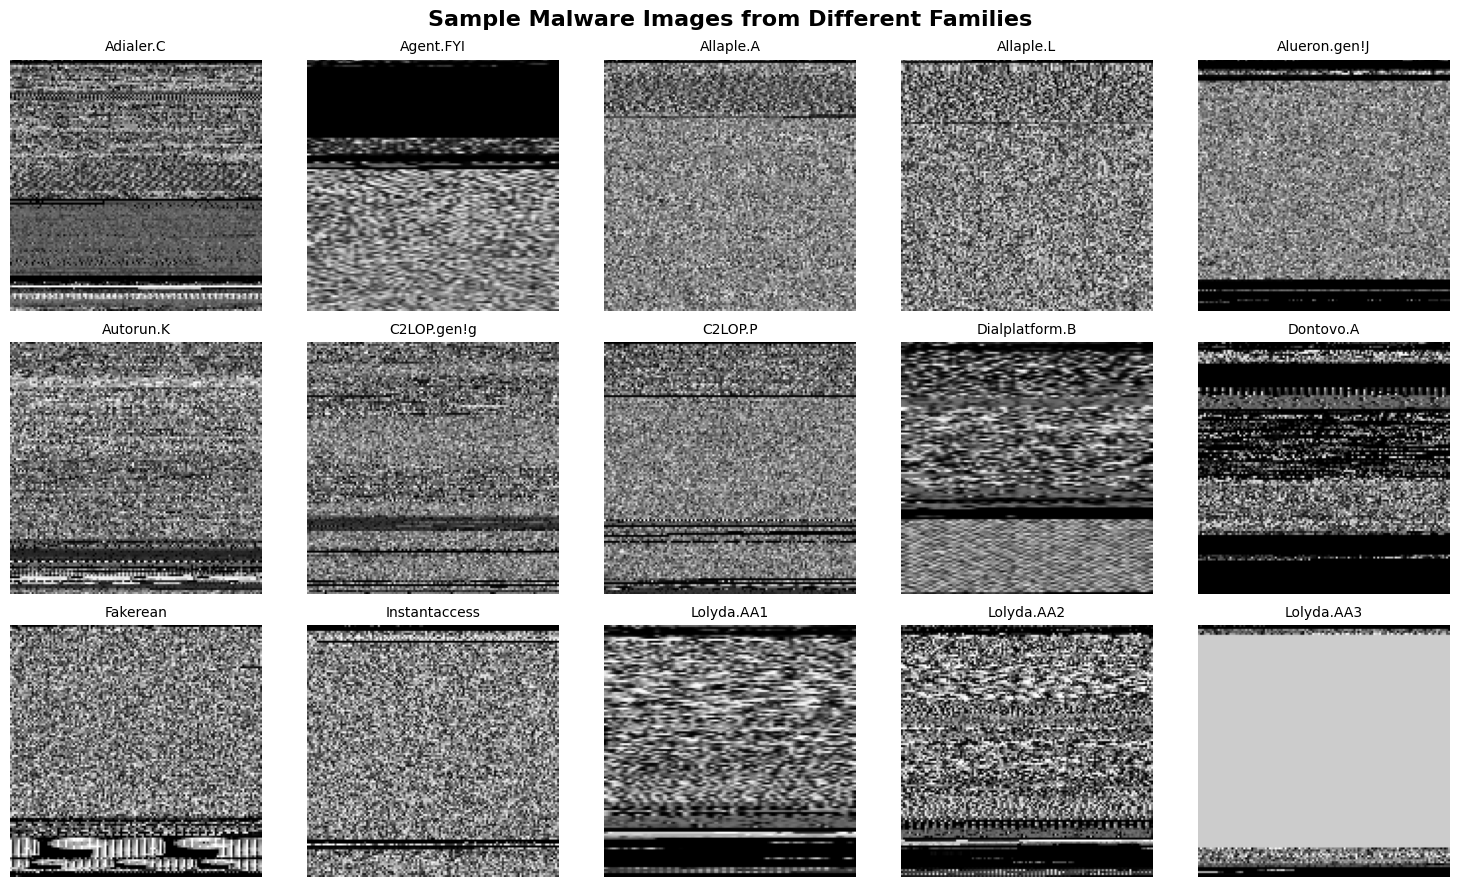

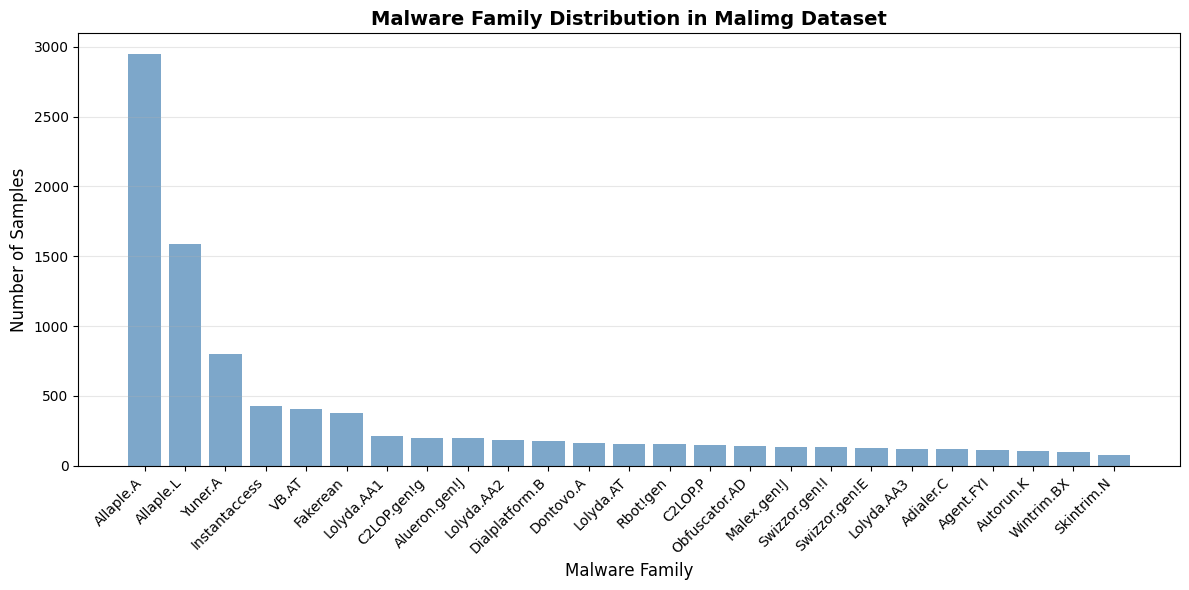

In [28]:
# Visualize sample images from each malware family
print("=== VISUALIZING SAMPLE IMAGES ===")

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Malware Images from Different Families', fontsize=16, fontweight='bold')

for idx, family in enumerate(malware_families[:15]):
    row = idx // 5
    col = idx % 5
    
    # Get first image from this family
    family_indices = np.where(labels == family)[0]
    if len(family_indices) > 0:
        sample_img = images[family_indices[0]]
        axes[row, col].imshow(sample_img, cmap='gray')
        axes[row, col].set_title(family, fontsize=10)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_distribution['Malware Family'], class_distribution['Count'], color='steelblue', alpha=0.7)
plt.xlabel('Malware Family', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Malware Family Distribution in Malimg Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Preprocess data for CNN
print("=== PREPROCESSING DATA ===")

# Normalize pixel values to [0, 1]
images_normalized = images.astype('float32') / 255.0

# Reshape for CNN input (add channel dimension)
images_normalized = images_normalized.reshape(-1, image_size[0], image_size[1], 1)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Class names: {label_encoder.classes_}")

# Convert labels to categorical (one-hot encoding)
labels_categorical = keras.utils.to_categorical(labels_encoded, num_classes)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images_normalized, labels_categorical, test_size=0.3, random_state=42, stratify=labels_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"\nData Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Input shape: {X_train.shape[1:]}")

=== PREPROCESSING DATA ===
Number of classes: 25
Class names: ['Adialer.C' 'Agent.FYI' 'Allaple.A' 'Allaple.L' 'Alueron.gen!J'
 'Autorun.K' 'C2LOP.P' 'C2LOP.gen!g' 'Dialplatform.B' 'Dontovo.A'
 'Fakerean' 'Instantaccess' 'Lolyda.AA1' 'Lolyda.AA2' 'Lolyda.AA3'
 'Lolyda.AT' 'Malex.gen!J' 'Obfuscator.AD' 'Rbot!gen' 'Skintrim.N'
 'Swizzor.gen!E' 'Swizzor.gen!I' 'VB.AT' 'Wintrim.BX' 'Yuner.A']
Number of classes: 25
Class names: ['Adialer.C' 'Agent.FYI' 'Allaple.A' 'Allaple.L' 'Alueron.gen!J'
 'Autorun.K' 'C2LOP.P' 'C2LOP.gen!g' 'Dialplatform.B' 'Dontovo.A'
 'Fakerean' 'Instantaccess' 'Lolyda.AA1' 'Lolyda.AA2' 'Lolyda.AA3'
 'Lolyda.AT' 'Malex.gen!J' 'Obfuscator.AD' 'Rbot!gen' 'Skintrim.N'
 'Swizzor.gen!E' 'Swizzor.gen!I' 'VB.AT' 'Wintrim.BX' 'Yuner.A']

Data Split:
Training set: 6537 samples
Validation set: 1401 samples
Test set: 1401 samples
Input shape: (128, 128, 1)

Data Split:
Training set: 6537 samples
Validation set: 1401 samples
Test set: 1401 samples
Input shape: (128, 128, 1)


## Build EfficientNetV2 Model

Use transfer learning with EfficientNetV2B0 pretrained on ImageNet. Adapt for grayscale malware images.

In [30]:
# Convert grayscale to RGB (EfficientNet requires 3 channels)
print("=== CONVERTING GRAYSCALE TO RGB ===")

X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

print(f"Training shape (RGB): {X_train_rgb.shape}")
print(f"Validation shape (RGB): {X_val_rgb.shape}")
print(f"Test shape (RGB): {X_test_rgb.shape}")

=== CONVERTING GRAYSCALE TO RGB ===
Training shape (RGB): (6537, 128, 128, 3)
Validation shape (RGB): (1401, 128, 128, 3)
Test shape (RGB): (1401, 128, 128, 3)
Training shape (RGB): (6537, 128, 128, 3)
Validation shape (RGB): (1401, 128, 128, 3)
Test shape (RGB): (1401, 128, 128, 3)


In [31]:
# Build EfficientNetV2 Model
print("=== BUILDING EFFICIENTNETV2 MODEL ===")

from tensorflow.keras.applications import EfficientNetV2B0

def create_efficientnetv2_model(input_shape, num_classes):
    """
    Create EfficientNetV2B0 model for malware classification
    """
    # Load pretrained EfficientNetV2B0 (without top classification layer)
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    
    # Freeze base model layers for transfer learning
    base_model.trainable = False
    
    # Build complete model
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
input_shape = X_train_rgb.shape[1:]
model = create_efficientnetv2_model(input_shape, num_classes)

# Print model summary
print("\nModel Summary:")
model.summary()
print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

=== BUILDING EFFICIENTNETV2 MODEL ===

Model Summary:

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,718,057 (25.63 MB)

 Trainable params: 796,185 (3.04 MB)

 Non-trainable params: 5,921,872 (22.59 MB)


Total parameters: 6,718,057
Trainable parameters: 796,185


## Compile and Train Model

Train EfficientNetV2 model with frozen pretrained weights for fast convergence.

In [32]:
# Compile the model
print("=== COMPILING MODEL ===")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("Optimizer: Adam (lr=0.0001)")
print("Loss: Categorical Crossentropy")

=== COMPILING MODEL ===
Model compiled successfully!
Optimizer: Adam (lr=0.0001)
Loss: Categorical Crossentropy


In [37]:
# Train the model - Phase 1: Train top layers only
print("=== TRAINING MODEL - PHASE 1: TOP LAYERS ONLY ===")
print(f"Training samples: {X_train_rgb.shape[0]}")
print(f"Validation samples: {X_val_rgb.shape[0]}")
print(f"Batch size: 16")
print(f"Epochs: 15")

history_phase1 = model.fit(
    X_train_rgb, y_train,
    batch_size=16,
    epochs=15,
    validation_data=(X_val_rgb, y_val),
    verbose=1
)

print("\nPhase 1 Training completed!")
print(f"Phase 1 Final Val Accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")

=== TRAINING MODEL - PHASE 1: TOP LAYERS ONLY ===
Training samples: 6537
Validation samples: 1401
Batch size: 16
Epochs: 15
Epoch 1/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 110s 269ms/step - accuracy: 0.5859 - loss: 1.4009 - val_accuracy: 0.7123 - val_loss: 0.9553
Epoch 2/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 108s 263ms/step - accuracy: 0.5923 - loss: 1.3992 - val_accuracy: 0.7116 - val_loss: 0.9208
Epoch 3/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 115s 282ms/step - accuracy: 0.5883 - loss: 1.4421 - val_accuracy: 0.7059 - val_loss: 0.9228
Epoch 4/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 122s 298ms/step - accuracy: 0.6035 - loss: 1.3711 - val_accuracy: 0.7145 - val_loss: 0.9187
Epoch 5/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 224s 547ms/step - accuracy: 0.5997 - loss: 1.3573 - val_accuracy: 0.7102 - val_loss: 0.9142
Epoch 6/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 122s 298ms/step - accuracy: 0.6145 - loss: 1.3202 - val_accuracy: 0.7195 - val_loss: 0.8751
Epoch 7/15
409/409 ━━━━━━━━━━━━━━━━━━━━ 107s 261ms/step - accuracy: 0.6104 - loss: 1

In [ ]:
# Train the model - Phase 2: Fine-tune with unfrozen layers
print("\n=== TRAINING MODEL - PHASE 2: FINE-TUNING ===")

# Unfreeze the last 30 layers of base model for fine-tuning
base_model = model.layers[0]
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Base model layers: {len(base_model.layers)}")
print(f"Trainable layers: {sum([1 for layer in base_model.layers if layer.trainable])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),  # Very low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with lr=0.00001 for fine-tuning")

# Data augmentation for phase 2
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print("\nData augmentation configured:")
print("  - Rotation: ±15 degrees")
print("  - Shift: ±10%")
print("  - Horizontal flip: Yes")
print("  - Zoom: ±10%")

# Continue training with fine-tuning
print(f"\nPhase 2 Training:")
print(f"Batch size: 16")
print(f"Epochs: 15")

history_phase2 = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=16),
    epochs=15,
    validation_data=(X_val_rgb, y_val),
    verbose=1
)

print("\nPhase 2 Training completed!")
print(f"Phase 2 Final Val Accuracy: {history_phase2.history['val_accuracy'][-1]:.4f}")

## Training History Visualization

Visualize both training phases: Initial training and fine-tuning.

=== VISUALIZING TRAINING HISTORY ===


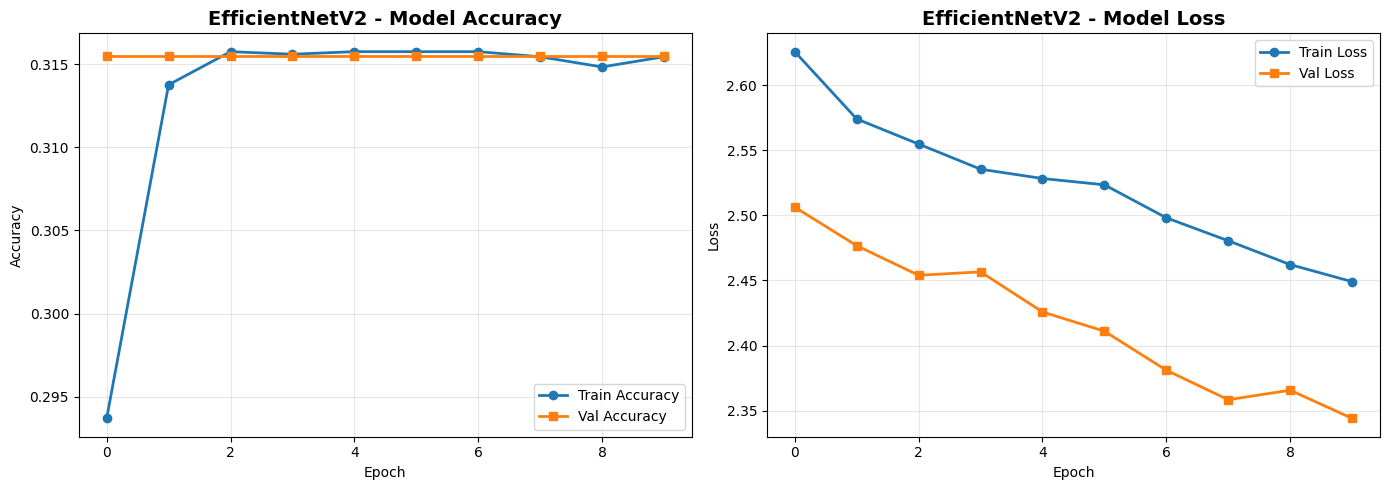


Final Training Accuracy: 0.3154
Final Validation Accuracy: 0.3155


In [ ]:
# Plot training history for both phases
print("=== VISUALIZING TRAINING HISTORY ===")

# Combine histories
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
epochs_phase1 = len(history_phase1.history['accuracy'])
total_epochs = len(combined_history['accuracy'])

axes[0].plot(range(1, total_epochs + 1), combined_history['accuracy'], 
             label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0].plot(range(1, total_epochs + 1), combined_history['val_accuracy'], 
             label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[0].axvline(x=epochs_phase1, color='red', linestyle='--', linewidth=2, 
                label=f'Fine-tuning starts (epoch {epochs_phase1})')
axes[0].set_title('EfficientNetV2 - Model Accuracy (2 Phases)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(range(1, total_epochs + 1), combined_history['loss'], 
             label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[1].plot(range(1, total_epochs + 1), combined_history['val_loss'], 
             label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[1].axvline(x=epochs_phase1, color='red', linestyle='--', linewidth=2, 
                label=f'Fine-tuning starts (epoch {epochs_phase1})')
axes[1].set_title('EfficientNetV2 - Model Loss (2 Phases)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPhase 1 (epochs 1-{epochs_phase1}):")
print(f"  Final Training Accuracy: {history_phase1.history['accuracy'][-1]:.4f}")
print(f"  Final Validation Accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")

print(f"\nPhase 2 (epochs {epochs_phase1+1}-{total_epochs}):")
print(f"  Final Training Accuracy: {history_phase2.history['accuracy'][-1]:.4f}")
print(f"  Final Validation Accuracy: {history_phase2.history['val_accuracy'][-1]:.4f}")

print(f"\nOverall Improvement:")
print(f"  Val Accuracy: {history_phase1.history['val_accuracy'][-1]:.4f} → {history_phase2.history['val_accuracy'][-1]:.4f}")
print(f"  Improvement: +{(history_phase2.history['val_accuracy'][-1] - history_phase1.history['val_accuracy'][-1]):.4f}")

## Model Evaluation on Test Set

Comprehensive evaluation with confusion matrix and per-class metrics.

In [12]:
# Evaluate on test set
print("=== EVALUATING MODEL ON TEST SET ===")

# Get predictions
y_pred_proba = model.predict(X_test_rgb, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_labels, y_pred)

print(f"\n=== TEST SET PERFORMANCE ===")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate overall metrics
from sklearn.metrics import precision_score, recall_score, f1_score

test_precision = precision_score(y_test_labels, y_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_pred, average='weighted')

print(f"Test Precision (weighted): {test_precision:.4f}")
print(f"Test Recall (weighted): {test_recall:.4f}")
print(f"Test F1-Score (weighted): {test_f1:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Calculate TPR, FPR, FNR for multi-class
TN = []
FP = []
FN = []
TP = []

for i in range(num_classes):
    y_true_binary = (y_test_labels == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
    
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

TPR_macro = np.mean([TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)])
FPR_macro = np.mean([FP[i] / (FP[i] + TN[i]) if (FP[i] + TN[i]) > 0 else 0 for i in range(num_classes)])
FNR_macro = np.mean([FN[i] / (FN[i] + TP[i]) if (FN[i] + TP[i]) > 0 else 0 for i in range(num_classes)])

print(f"\n=== MACRO-AVERAGED RATES ===")
print(f"TPR (True Positive Rate): {TPR_macro:.4f}")
print(f"FPR (False Positive Rate): {FPR_macro:.4f}")
print(f"FNR (False Negative Rate): {FNR_macro:.4f}")

=== EVALUATING MODEL ON TEST SET ===

=== TEST SET PERFORMANCE ===
Test Accuracy: 0.3162
Test Precision (weighted): 0.1000
Test Recall (weighted): 0.3162
Test F1-Score (weighted): 0.1519

=== MACRO-AVERAGED RATES ===
TPR (True Positive Rate): 0.0400
FPR (False Positive Rate): 0.0400
FNR (False Negative Rate): 0.9600

=== TEST SET PERFORMANCE ===
Test Accuracy: 0.3162
Test Precision (weighted): 0.1000
Test Recall (weighted): 0.3162
Test F1-Score (weighted): 0.1519

=== MACRO-AVERAGED RATES ===
TPR (True Positive Rate): 0.0400
FPR (False Positive Rate): 0.0400
FNR (False Negative Rate): 0.9600


e:\software\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Classification Report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
class_names = label_encoder.classes_
report = classification_report(y_test_labels, y_pred, target_names=class_names, digits=4)
print(report)


=== DETAILED CLASSIFICATION REPORT ===
                precision    recall  f1-score   support

     Adialer.C     0.0000    0.0000    0.0000        18
     Agent.FYI     0.0000    0.0000    0.0000        18
     Allaple.A     0.3162    1.0000    0.4805       443
     Allaple.L     0.0000    0.0000    0.0000       239
 Alueron.gen!J     0.0000    0.0000    0.0000        29
     Autorun.K     0.0000    0.0000    0.0000        16
       C2LOP.P     0.0000    0.0000    0.0000        22
   C2LOP.gen!g     0.0000    0.0000    0.0000        30
Dialplatform.B     0.0000    0.0000    0.0000        27
     Dontovo.A     0.0000    0.0000    0.0000        24
      Fakerean     0.0000    0.0000    0.0000        57
 Instantaccess     0.0000    0.0000    0.0000        65
    Lolyda.AA1     0.0000    0.0000    0.0000        32
    Lolyda.AA2     0.0000    0.0000    0.0000        28
    Lolyda.AA3     0.0000    0.0000    0.0000        19
     Lolyda.AT     0.0000    0.0000    0.0000        24
   Male

e:\software\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== CONFUSION MATRIX ===


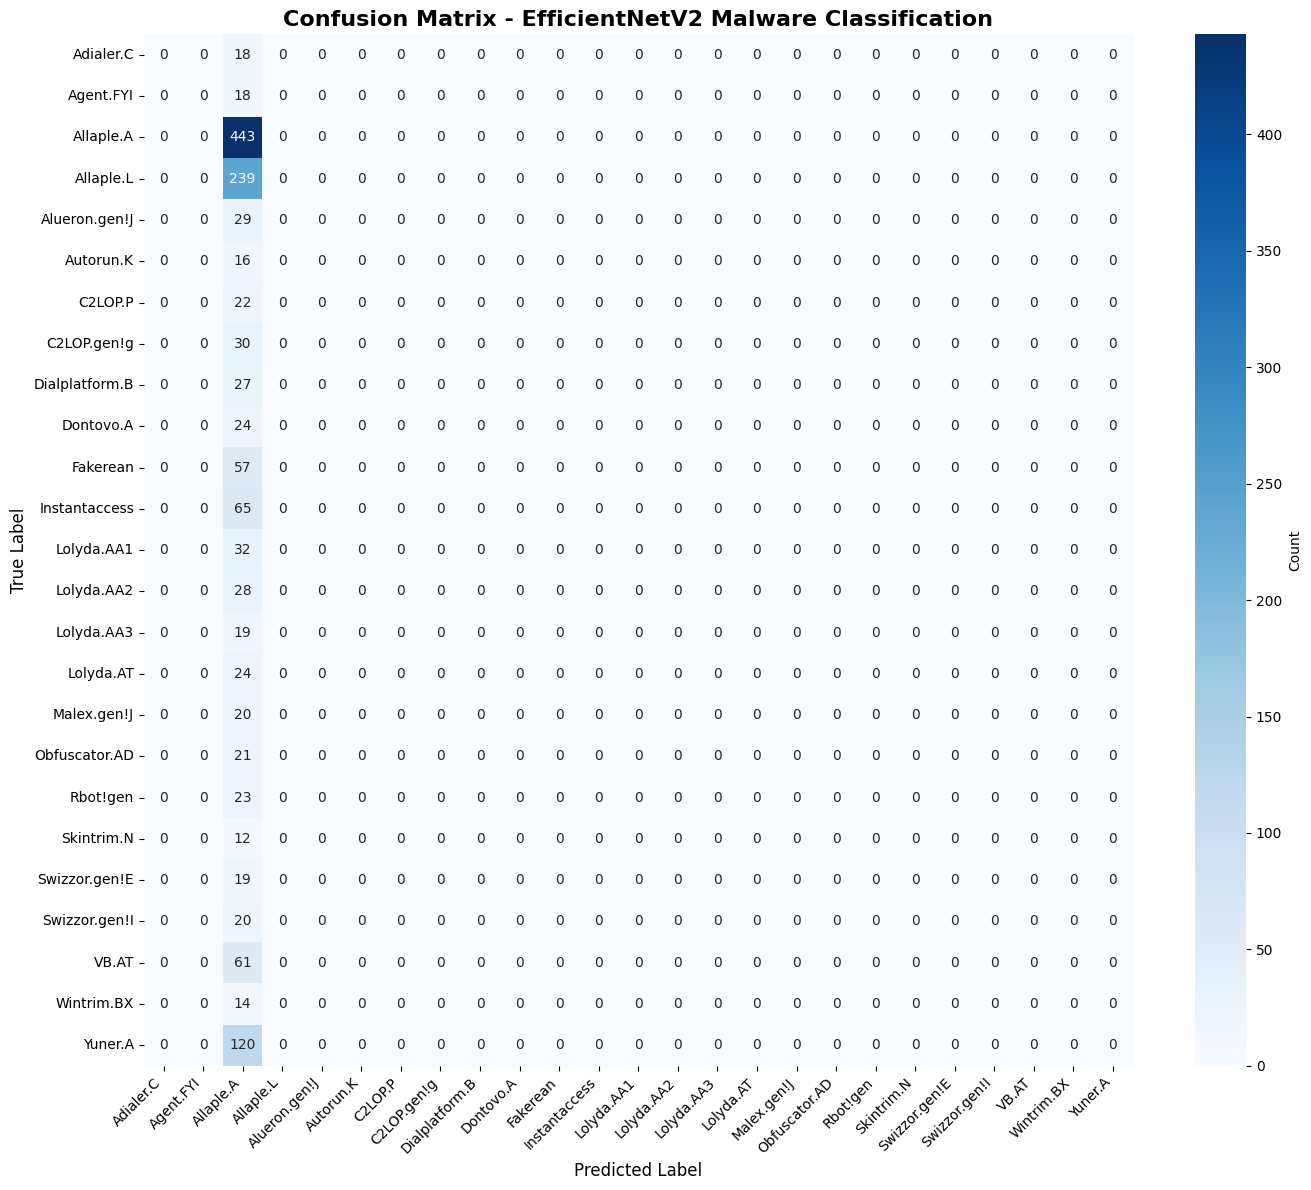

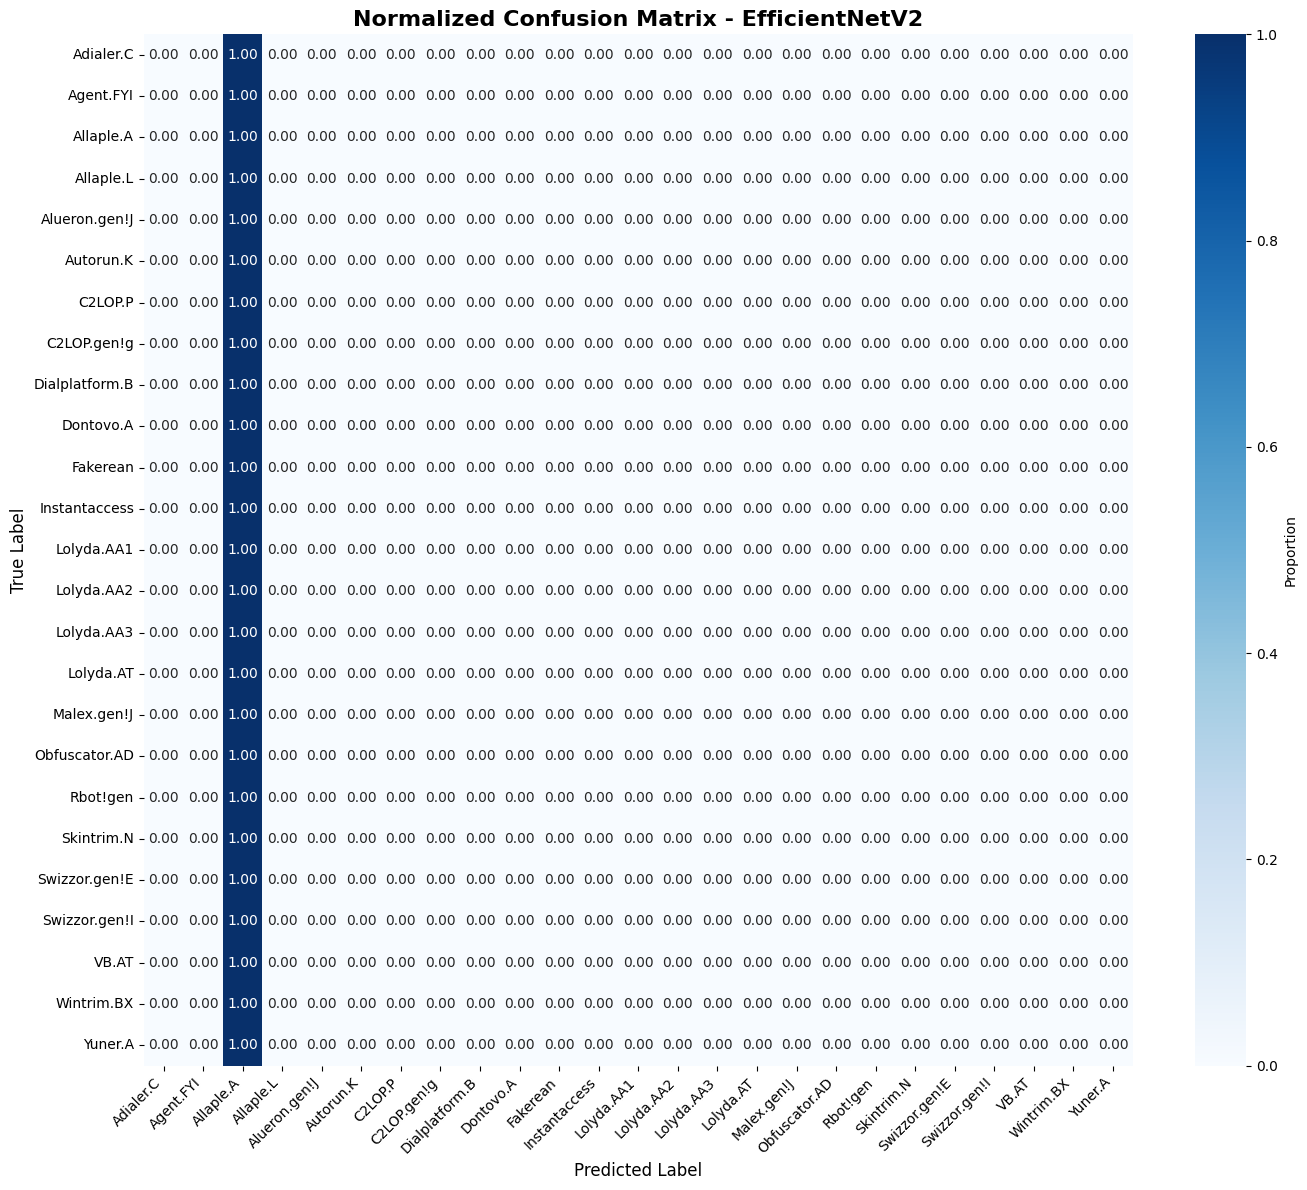

In [14]:
# Plot confusion matrix
print("=== CONFUSION MATRIX ===")

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - EfficientNetV2 Malware Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
plt.figure(figsize=(14, 12))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix - EfficientNetV2', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

=== PER-CLASS PERFORMANCE ===
Malware Family  Precision  Recall  F1-Score  Support
     Allaple.A   0.316203     1.0  0.480477      443
     Adialer.C   0.000000     0.0  0.000000       18
     Agent.FYI   0.000000     0.0  0.000000       18
     Allaple.L   0.000000     0.0  0.000000      239
 Alueron.gen!J   0.000000     0.0  0.000000       29
     Autorun.K   0.000000     0.0  0.000000       16
       C2LOP.P   0.000000     0.0  0.000000       22
   C2LOP.gen!g   0.000000     0.0  0.000000       30
Dialplatform.B   0.000000     0.0  0.000000       27
     Dontovo.A   0.000000     0.0  0.000000       24
      Fakerean   0.000000     0.0  0.000000       57
 Instantaccess   0.000000     0.0  0.000000       65
    Lolyda.AA1   0.000000     0.0  0.000000       32
    Lolyda.AA2   0.000000     0.0  0.000000       28
    Lolyda.AA3   0.000000     0.0  0.000000       19
     Lolyda.AT   0.000000     0.0  0.000000       24
   Malex.gen!J   0.000000     0.0  0.000000       20
 Obfuscator.AD  

e:\software\python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


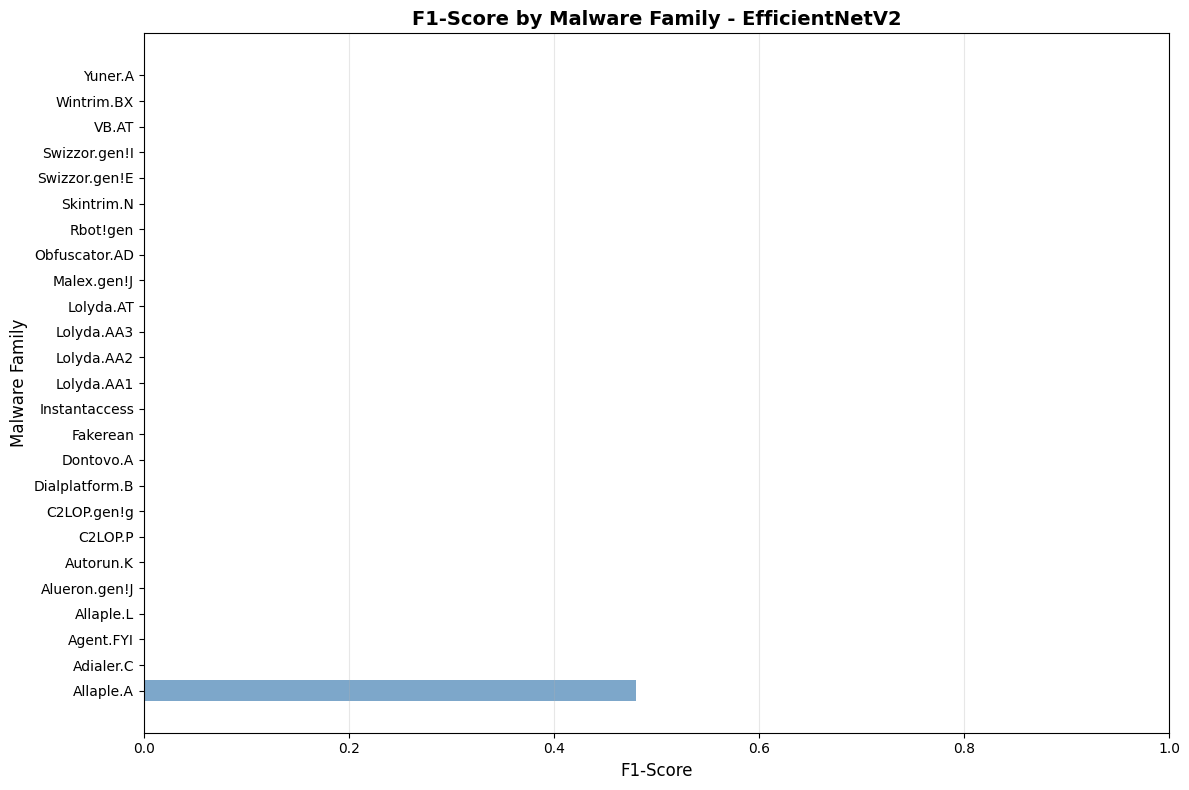

In [15]:
# Per-class performance
print("=== PER-CLASS PERFORMANCE ===")

from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_test_labels, y_pred, labels=range(num_classes)
)

performance_df = pd.DataFrame({
    'Malware Family': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support
})

performance_df = performance_df.sort_values('F1-Score', ascending=False)
print(performance_df.to_string(index=False))

# Plot per-class F1-scores
plt.figure(figsize=(12, 8))
plt.barh(performance_df['Malware Family'], performance_df['F1-Score'], color='steelblue', alpha=0.7)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Malware Family', fontsize=12)
plt.title('F1-Score by Malware Family - EfficientNetV2', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Model and Results

In [ ]:
# Save the model
print("=== SAVING MODEL ===")

model.save('malware_efficientnetv2_model.h5')
print("Model saved as 'malware_efficientnetv2_model.h5'")

# Save performance metrics
metrics_dict = {
    'model': 'EfficientNetV2B0',
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'TPR_macro': TPR_macro,
    'FPR_macro': FPR_macro,
    'FNR_macro': FNR_macro,
    'total_params': model.count_params()
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv('efficientnetv2_performance_metrics.csv', index=False)
print("Performance metrics saved as 'efficientnetv2_performance_metrics.csv'")

print("\n=== FINAL SUMMARY ===")
print(f"Model: EfficientNetV2B0 with {model.count_params():,} parameters")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Number of Classes: {num_classes}")
print(f"Total Test Samples: {len(y_test_labels)}")